# Text drift detection 

We are going to see if we can spot the difference between different 
20newsgroups dataset. 

We can easily download sentences:

In [1]:
import sys 
sys.path.append("../../") # Adding path to project root for this specific notebook

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups

train_space = fetch_20newsgroups(subset='train', categories=["sci.space"])["data"]
test_space = fetch_20newsgroups(subset='test', categories=["sci.space"])["data"]
train_electronics = fetch_20newsgroups(subset='train', categories=["sci.electronics"])["data"]
train_talk = fetch_20newsgroups(subset='train', categories=["talk.politics.mideast"])["data"]


Let's see the example sentences from two of them:

In [3]:
train_talk[0]

'From: smortaz@handel.sun.com (shahrokh mortazavi)\nSubject: Re: News briefs from KH # 1025\nOrganization: Central\nLines: 18\n\nIn article <1qg1gdINNge7@anaconda.cis.ohio-state.edu> karbasi@cis.ohio-state.edu writes:\n\n>\n>\t1- "nehzat-e aazaadee"\'s member have many times been arrested\n>\tand tortured and as we speak some of them are still in prison.\n>\n>\t2- The above item confirms the long standing suspicion that \n>\tthe only reason this regime has not destroyed "nehzat-e\n>\taazaadee" completely is just to show off and brag about the\n>\t"freedom of expression in Iran" in its propaganda paper.\n>\n>\tGet serious!  If this regime had its way, there would be \n>\tabsolutely no freedom of expression anywhere, not even in SCI.  \n\t\t\t\t\t\t      ^^^^^^^^^^^^^^^\n\nthere really isnt, as seen by the heavy usage of anonymous posting.  \nif iri sympathizers didnt roam around in sci, anon-poster would \nget used only occasionally (as in the good old days).\n'

In [4]:
train_space[0]

"From: henry@zoo.toronto.edu (Henry Spencer)\nSubject: Re: japanese moon landing?\nOrganization: U of Toronto Zoology\nLines: 21\n\nIn article <1qnb9tINN7ff@rave.larc.nasa.gov> C.O.EGALON@LARC.NASA.GOV (CLAUDIO OLIVEIRA EGALON) writes:\n>> there is no such thing as a stable lunar orbit\n>\n>Is it right??? That is new stuff for me. So it means that  you just can \n>not put a sattellite around around the Moon for too long because its \n>orbit will be unstable??? If so, what is the reason??? Is that because \n>the combined gravitacional atraction of the Sun,Moon and Earth \n>that does not provide a stable  orbit around the Moon???\n\nAny lunar satellite needs fuel to do regular orbit corrections, and when\nits fuel runs out it will crash within months.  The orbits of the Apollo\nmotherships changed noticeably during lunar missions lasting only a few\ndays.  It is *possible* that there are stable orbits here and there --\nthe Moon's gravitational field is poorly mapped -- but we know of no

In [5]:
train_electronics[0]

"From: rogerw@world.std.com (Roger A Williams)\nSubject: Re: 68HC16 public domain software?\nOrganization: The World Public Access UNIX, Brookline, MA\nLines: 1\n\nDoesn't Motorola AMCU have something on the BBS yet? (512-891-3733)\n"

What we want to do is we want to train drift detector on training `space` data,
and see, if testing `space` data will not be detected as a different
distribution.

After that, we want to see that `electronics` data is a different distribution,
however more similar than `talk` distribution. 

A successful experiment will show the differences clearly.

Let's initialize the client:

In [6]:
from drifting import DriftingClient, DriftType

client = DriftingClient()
detector_name = "SpaceTextDrift"

Now we fit the detector on training `space` data and load it:

In [7]:
client.fit(train_space, drift_type=DriftType.TEXT, detector_name=detector_name, ert=400, window_size=40, n_bootstraps=7000)

<Response [200]>

In [8]:
client.load(detector_name)

<Response [200]>

The last part is to run the detector on each set. We will test it on both
`space` datasets hoping it will not classify them as drifted.
All the sets are concatenated, we pass the sentence one by one, imitating
the real use-case in online system.

In [9]:
all_sets = train_space + test_space + train_electronics + train_talk
drifts, test_stats = [], []
for i in range(len(all_sets)):
    is_drift, test_stat = client.predict(
        [all_sets[i]], drift_type=DriftType.TEXT, detector_name=detector_name
    )
    # print(response)
    test_stats.append(test_stat)
    if is_drift:
        # The drift detector indicates after each sample if there is a drift in the data
        drifts.append(i)


Text(0.5, 1.0, 'Detections on different datasets')

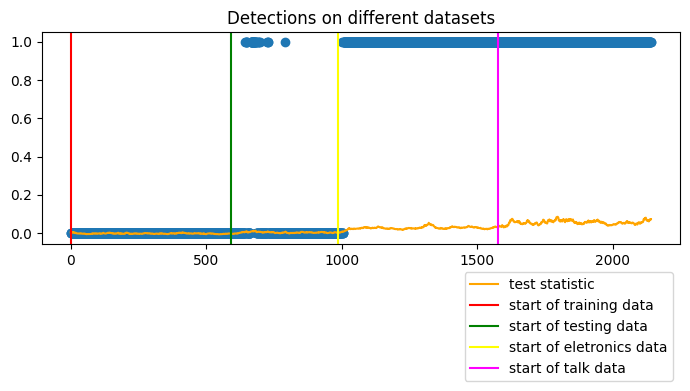

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,4), tight_layout=True)

detections = np.zeros((len(all_sets, )))
detections[drifts] = 1
plt.plot(detections, "o")
plt.plot(test_stats, 'orange', label="test statistic")
plt.axvline(0, color='red', label="start of training data")
plt.axvline(len(train_space), color='green', label="start of testing data")
plt.axvline(len(train_space)+len(test_space), color='yellow', label="start of eletronics data")
plt.axvline(len(train_space)+len(test_space)+len(train_electronics), color='magenta', label="start of talk data")
plt.legend(loc='upper right', bbox_to_anchor=(1,-0.1))
plt.title("Detections on different datasets")


As we can see, detector noticed both training and testing `space` sentences come
from the same distribution, whereas `electronics` and `talk` data are drifted.